In [383]:
# Core imports
import heyoka as hk
import pykep as pk
import numpy as np
from numpy import linalg as la
import pandas as pd
import math
from numpy.lib.function_base import append
from scipy.integrate import odeint
# Sys imports
import time
# Plot imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from UROP_aux_func import rv2elorb

In [384]:
"""
Constant parameters 
"""

GMe = 398601   #[km^3/sec^2]
Re  = 6371.22  #[km]
J2 = 0.00108265         # [-] second zonal harmonic
GMl = 4902.66 #[km^3/sec^2] for the Moon
rl = 384400   #[km] radius of the lunar orbit
omega_l = 2.665315780887e-6 #[1/s] lunar orbital angular velocity

In [444]:
# create heyoka variables
tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4 = hk.make_vars("tau", "zeta1", "zeta2", "zeta3",
                                                                "eta1", "eta2", "eta3", "eta4")

In [445]:
# Step 1: Define Initial Conditions (dimensional)
r0 = np.array([0.0, -5888.9727, -3400.0]) #km   (class 'numpy.ndarray')
v0 = np.array([10.691338, 0.0, 0.0])      #km/s
[a0, e0_norm, i0, RAAN0, omega0, theta0] = rv2elorb(r0, v0, GMe)

In [446]:
# Step 2: non-dimensionalise 
r0nd = r0 / a0 #[km/km] = [-] since the orbit is highly elliptical normalise with the initial semimajor axis
               # otherwise use r0nd = r0/la.norm(r0)
v0nd = v0 * math.sqrt(a0/GMe)    #[-]
t0   = 0                         #s
t0nd = t0 / math.sqrt((a0**3)/GMe) #[-]
# Non-dimensionalise the parameters
GMend = 1 # GMe * a0d / (a0d * GMe) 
Rend  = Re / a0
rlnd  = rl / a0
omega_lnd = omega_l * math.sqrt((a0**3)/GMe)
GMlnd = GMl / GMe

In [447]:
# Step 3: tranform the non-dimensional ICs (r0nd, v0nd) in DROMO elements 
h0 = np.cross(r0nd, v0nd)                      # 3-components vector
e0 = - r0nd/la.norm(r0nd) - np.cross(h0, v0nd) # 3-components vector
# sigma0 from page 7. and from page 14. (initial conditions)
sigma0 = theta0 

In [448]:
# Initial state (sigma; tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4)
tau_0   = t0nd
zeta1_0 = la.norm(e0)
zeta2_0 = 0
zeta3_0 = 1/la.norm(h0)
eta1_0  = math.sin(i0/2)*math.cos((RAAN0-omega0)/2)
eta2_0  = math.sin(i0/2)*math.sin((RAAN0-omega0)/2)
eta3_0  = math.cos(i0/2)*math.sin((RAAN0+omega0)/2)
eta4_0  = math.cos(i0/2)*math.cos((RAAN0+omega0)/2)
S0 = [tau_0, zeta1_0, zeta2_0, zeta3_0, eta1_0, eta2_0, eta3_0, eta4_0]

In [449]:
# Valore finale di sigma
sigma_fin = 60*2*np.pi     # rad  311.10986051
fin_day =  288.1276894125 # days
# numero di passi per orbita
# m = 1000
# N = math.floor((sigma_fin - sigma0)/(2*np.pi)) * m
delta_sigma = 0.002   
N = math.floor((sigma_fin-sigma0)/delta_sigma - 1)
sigma_span = np.linspace(sigma0, sigma_fin, N)  

In [450]:
# Auxiliary relationships
s = 1 + zeta1 * hk.cos(hk.time) + zeta2 * hk.sin(hk.time)

In [451]:
# convert from Dromo to State (with heyoka variable)
def dromo2rv_hk(Lc, sigma, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4):
    """
    If you want to have r,v non dimensional from dromo, let Lc be 1.
    Dromo elements to cartesian representation of state vector (page 14)
    Outputs: Dimensional components of position and velocity
    """
    s = 1 + zeta1 * hk.cos(sigma) + zeta2 * hk.sin(sigma)
    alpha = (Lc / (zeta3**2 * s))
    omegacLc = (math.sqrt(GMe/Lc**3) * Lc)

    p11 = 1-2*(eta2**2 + eta3**2)
    p12 = 2*eta1*eta2 - 2*eta4*eta3
    p21 = 2*eta1*eta2 + 2*eta4*eta3
    p22 = 1-2*(eta1**2 + eta3**2)
    p31 = 2*eta1*eta3 - 2*eta4*eta2
    p32 = 2*eta3*eta2 + 2*eta4*eta1

    x = alpha * ( p11*hk.cos(sigma) + p12*hk.sin(sigma) )
    y = alpha * ( p21*hk.cos(sigma) + p22*hk.sin(sigma) )
    z = alpha * ( p31*hk.cos(sigma) + p32*hk.sin(sigma) ) 

    V1 = -zeta3*(hk.sin(sigma)+zeta2)
    V2 =  zeta3*(hk.cos(sigma)+zeta1)

    xv = omegacLc * ( p11*V1 + p12*V2 )
    yv = omegacLc * ( p21*V1 + p22*V2 )
    zv = omegacLc * ( p31*V1 + p32*V2 ) 
    return x, y, z, xv, yv, zv 

In [452]:
# convert from Dromo to State (with numeric variable)
def dromo2rv(Lc, sigma, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4):
    """
    If you want to have r,v non dimensional from dromo, let Lc be 1.
    Dromo elements to cartesian representation of state vector (page 14)
    Outputs: Dimensional components of position and velocity
    """
    s = 1 + zeta1 * np.cos(sigma) + zeta2 * np.sin(sigma)
    alpha = (Lc / (zeta3**2 * s))
    omegacLc = (math.sqrt(GMe/Lc**3) * Lc)

    p11 = 1-2*(eta2**2 + eta3**2)
    p12 = 2*eta1*eta2 - 2*eta4*eta3
    p21 = 2*eta1*eta2 + 2*eta4*eta3
    p22 = 1-2*(eta1**2 + eta3**2)
    p31 = 2*eta1*eta3 - 2*eta4*eta2
    p32 = 2*eta3*eta2 + 2*eta4*eta1

    x = alpha * ( p11*np.cos(sigma) + p12*np.sin(sigma) )
    y = alpha * ( p21*np.cos(sigma) + p22*np.sin(sigma) )
    z = alpha * ( p31*np.cos(sigma) + p32*np.sin(sigma) ) 

    V1 = -zeta3*(np.sin(sigma)+zeta2)
    V2 =  zeta3*(np.cos(sigma)+zeta1)

    xv = omegacLc * ( p11*V1 + p12*V2 )
    yv = omegacLc * ( p21*V1 + p22*V2 )
    zv = omegacLc * ( p31*V1 + p32*V2 ) 
    return x, y, z, xv, yv, zv 

In [453]:
x,  y,  z, xv, yv, zv = dromo2rv_hk(a0, hk.time, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4)
x,  y,  z  = x/a0, y/a0, z/a0
xv, yv, zv = xv*math.sqrt(a0/GMe), yv*math.sqrt(a0/GMe), zv*math.sqrt(a0/GMe)


In [454]:
# Create vectors (Non dimensional) 
r = np.array([x,  y,  z])  # r.shape  = (3, 1)
v = np.array([xv, yv, zv]) 
r_norm = (r[0]**2 + r[1]**2 + r[2]**2)**(1/2)  


In [455]:
# Define the unit vectors of the (local) orbital frame
io = r / r_norm
hx, hy, hz = np.cross(r, v, axis=0)
h_norm = (hx**2 + hy**2 + hz**2)**(1/2)   
ko = np.cross(r, v, axis=0) / h_norm
jo = np.cross(ko, io, axis=0)

In [456]:
# J2
#Earth's J2 terms
fJ2X = ( (3/2)*J2*Rend**2/r_norm**4 ) * (x/r_norm)*(5*(z**2/r_norm**2) -1)
fJ2Y = ( (3/2)*J2*Rend**2/r_norm**4 ) * (y/r_norm)*(5*(z**2/r_norm**2) -1)
fJ2Z = ( (3/2)*J2*Rend**2/r_norm**4 ) * (z/r_norm)*(5*(z**2/r_norm**2) -3)

# Third body (moon)
r3 = np.array([ rlnd * hk.sin(omega_lnd*tau),
                rlnd * (- (math.sqrt(3)*hk.cos(omega_lnd*tau))/2) ,
                rlnd * (- hk.cos(omega_lnd*tau)/2)])
r3_norm  = (r3[0]**2 + r3[1]**2 + r3[2]**2)**(1/2)
r3r      = r3 - np.array([x, y, z])
r3r_norm = (r3r[0]**2 + r3r[1]**2 + r3r[2]**2)**(1/2)

fLX = GMlnd * ( (r3[0] - x)/(r3r_norm**3) - r3[0]/(r3_norm**3) )
fLY = GMlnd * ( (r3[1] - y)/(r3r_norm**3) - r3[1]/(r3_norm**3) )
fLZ = GMlnd * ( (r3[2] - z)/(r3r_norm**3) - r3[2]/(r3_norm**3) )

# Superimpose the accelerations
apx = fJ2X + fLX 
apy = fJ2Y + fLY 
apz = fJ2Z + fLZ
acc = np.array([apx, apy, apz])

# Project into the orbital frame (from inertial frame)
api = np.dot(io, acc) # = apx*xx + apy*xy + apz*xz
apj = np.dot(jo, acc) # = apx*yx + apy*yy + apz*yz
apk = np.dot(ko, acc) # = apx*zx + apy*zy + apz*zz

# Perturbing accelerations
a_px = api/(zeta3**4 * s**3)
a_py = apj/(zeta3**4 * s**3)
a_pz = apk/(zeta3**4 * s**3)

In [457]:
#EOMs

# in heyoka is sigma equivalent to hk.time ?
dtaudsigma    = 1/((zeta3**3) * (s**2)) 
dzeta1dsigma  = s * hk.sin(hk.time)   * a_px   + (zeta1 + (1+s)*hk.cos(hk.time)) * a_py 
dzeta2dsigma  = - s * hk.cos(hk.time) * a_px   + (zeta2 + (1+s)*hk.sin(hk.time)) * a_py
dzeta3dsigma  = - zeta3 * a_py
deta1dsigma   = 1/2 * a_pz * (eta4 * hk.cos(hk.time) - eta3 * hk.sin(hk.time))
deta2dsigma   = 1/2 * a_pz * (eta3 * hk.cos(hk.time) + eta4 * hk.sin(hk.time))
deta3dsigma   = 1/2 * a_pz * (-eta2* hk.cos(hk.time) + eta1 * hk.sin(hk.time))
deta4dsigma   = 1/2 * a_pz * (-eta1* hk.cos(hk.time) - eta2 * hk.sin(hk.time))
                    

In [458]:
sigma_event = []
dromo_state_event = []
sol_event = []

# Callback for the terminal event.
def t_cb(ta, mr, d_sgn):
    # Append the event info
    sigma_event.append(ta.time)
    dromo_state_event.append(ta.state)
    sol_event.append(ta)
    # Do stop the integration.
    return False

t_ev = hk.t_event(
        # The event equation.
        ((tau * math.sqrt((a0**3)/GMe))/(24*3600)) - fin_day,
        # The callback.
        callback = t_cb)

In [459]:
print('Compiling the Taylor integrator ... (this is done only once)')
start_time = time.time()

ta = hk.taylor_adaptive(sys = [(tau,dtaudsigma),
                               (zeta1,dzeta1dsigma),
                               (zeta2,dzeta2dsigma),
                               (zeta3,dzeta3dsigma),
                               (eta1,deta1dsigma),
                               (eta2,deta2dsigma),
                               (eta3,deta3dsigma),
                               (eta4,deta4dsigma)],
                                state = S0,
                                time = sigma0,
                                tol = 1e-16,
                                compact_mode = True,
                                # The list of terminal events.
                                t_events = [t_ev])

# https://bluescarni.github.io/heyoka.py/notebooks/Event%20detection.html
#ta.propagate_until(t = 311.10986051) # if t is sigma (indep var) propagate until sigma_fin

end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))

print("\nHeyoka Taylor integrator:\n", ta)

# Can you give me any insight as to what the error means?

Compiling the Taylor integrator ... (this is done only once)
Done, in
--- 3.934126138687134 seconds ---

Heyoka Taylor integrator:
 Taylor order            : 20
Dimension               : 8
Time                    : 0.0000000000000000
State                   : [0.0000000000000000, 0.95000015413507943, 0.0000000000000000, 3.2025678858150046, -0.18301270304063946, -0.18301270304063952, 0.68301270158450111, -0.68301270158450100]
N of terminal events    : 1



In [460]:
# Here we redefine the initial conditions since we may want to change them without recompiling the integrator
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] =  S0

In [461]:
start_time = time.time()
out = ta.propagate_grid(sigma_span)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))

print(out)
sol = out[4] 
size1, size2 = np.shape(sol)
print(sol[-1], sol[-2], sol[-3])
print(f'the shape of the solution (cartesian form) is {size1, size2}') #(62216, 8)

# If True (69114, 8)

Done, in
--- 0.16520404815673828 seconds ---
(<taylor_outcome.???: -1>, 0.022030074253667837, 0.5438100991070369, 1721, array([[ 0.00000000e+00,  9.50000154e-01,  0.00000000e+00, ...,
        -1.83012703e-01,  6.83012702e-01, -6.83012702e-01],
       [ 1.60129685e-05,  9.50000156e-01,  7.12549522e-07, ...,
        -1.83012271e-01,  6.83012817e-01, -6.83012586e-01],
       [ 3.20259994e-05,  9.50000163e-01,  1.42512781e-06, ...,
        -1.83011840e-01,  6.83012933e-01, -6.83012469e-01],
       ...,
       [ 3.13059688e+02,  9.38193336e-01,  1.24026565e-01, ...,
        -1.71908748e-01,  6.85920011e-01, -6.80595082e-01],
       [ 3.13081712e+02,  9.38100286e-01,  1.24115130e-01, ...,
        -1.71921188e-01,  6.85916920e-01, -6.80599019e-01],
       [ 3.13103815e+02,  9.38005818e-01,  1.24202564e-01, ...,
        -1.71933778e-01,  6.85913793e-01, -6.80603020e-01]]))
[ 3.13103815e+02  9.38005818e-01  1.24202564e-01  3.07668532e+00
 -1.91678309e-01 -1.71933778e-01  6.85913793e-01 -6.80603

In [462]:
df_dromo = pd.DataFrame(sol, columns=["tau", "z1", "z2", "z3", "h1", "h2", "h3", "h4"])
#print(df_dromo.tail())
type(sol_event[0])   # heyoka.core._taylor_adaptive_dbl

print("sigma associated with event: ", sigma_event[0], "rad")
print("tau associated with event:   ", dromo_state_event[0][0])
print("while last tau of output is  ", sol[-1][0])
dromo2rv(a0, sigma_event[0], *dromo_state_event[0])
#(-24219.050293416265,
# 227962.1064595895,
# 129753.44244386554,
# -0.3072444681649876,
# 0.1539502028637808,
# 0.07809786487495467)

sigma associated with event:  311.10986050947207 rad
tau associated with event:    313.3701056148616
while last tau of output is   313.103815492126


(-24219.050182029176,
 227962.10640614215,
 129753.44241688402,
 -0.30724446834049995,
 0.15395020463765988,
 0.07809786588412296)

In [405]:
state = np.empty((size1, 6))
r_norm = np.empty((size1, 1))

for row in range(size1):
    state[row, :] = dromo2rv(a0, sigma_span[row], *sol[row, :])
    r_norm[row, 0] = math.sqrt(state[row, 0]**2 + state[row, 1]**2 + state[row, 2]**2 )

In [406]:

#print("initial state", state[0, :])
print("final state", state[-1, :])

tau_days = np.empty((size1, 1))
for t, i in zip(df_dromo["tau"], range(size1)):
    tau_days[i, 0] = ( t*math.sqrt((a0**3)/GMe) )/(24*3600)
    
print("last day: ", tau_days[-1, :]) 

# last day:  [287.82589286]

final state [-1.75609637e+04  2.23531469e+05  1.27436087e+05 -3.14082687e-01
  2.60490813e-01  1.38717763e-01]
last day:  [287.87978888]


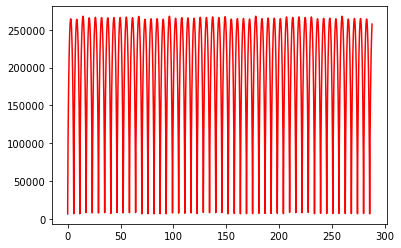

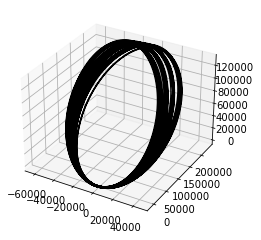

In [316]:
plt.plot(tau_days[:, 0], r_norm[:, 0], 'r')
plt.show()

df_pos = pd.DataFrame(state, columns=["x", "y", "z", "xv", "yv", "zv"])

ax = plt.axes(projection='3d')
ax.plot3D(df_pos["x"], df_pos["y"], df_pos["z"], color = 'k', label = 'orbit')
plt.show()
